In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

from torchvision import transforms

from PIL import Image
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import os


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-47b46eb1-fa80-0f83-8e3a-2f0b81d2788a)


In [3]:
from google.colab import drive

drive.mount(r'/content/drive')

Mounted at /content/drive


In [4]:

# ----- define model -----
class U_Net(nn.Module):

    def __init__(self):
        super().__init__()

        # contracting path
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3)

        #bottom path
        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3)
        self.conv10 = nn.Conv2d(1024, 1024, kernel_size=3)

        # expansive path
        self.conv11 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # explains about up-sampling: https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0
        self.conv12 = nn.Conv2d(1024, 512, kernel_size=3)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3)

        self.conv14 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(512, 256, kernel_size=3)
        self.conv16 = nn.Conv2d(256, 256, kernel_size=3)

        self.conv17 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv18 = nn.Conv2d(256, 128, kernel_size=3)
        self.conv19 = nn.Conv2d(128, 128, kernel_size=3)

        self.conv20 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv21 = nn.Conv2d(128, 64, kernel_size=3)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3)

        self.conv23 = nn.Conv2d(64, 1, kernel_size=1)

        # crop needed in expansive path
        self.crop1 = transforms.CenterCrop(56)
        self.crop2 = transforms.CenterCrop(104)
        self.crop3 = transforms.CenterCrop(200)
        self.crop4 = transforms.CenterCrop(392)

    def forward(self, x):

        # contracting path
        out = torch.relu(self.conv2(torch.relu(self.conv1(x))))
        out1 = out
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv4(torch.relu(self.conv3(out))))
        out2 = out
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv6(torch.relu(self.conv5(out))))
        out3 = out
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv8(torch.relu(self.conv7(out))))
        out4 = out
        out = F.max_pool2d(out, 2)

        # bottom path
        out = torch.relu(self.conv10(torch.relu(self.conv9(out))))

        # expansive path

        out4 = self.crop1(out4)
        out = self.conv13(torch.relu(self.conv12(torch.relu(torch.cat([self.conv11(out), out4], dim=1)))))

        out3 = self.crop2(out3)
        out = self.conv16(torch.relu(self.conv15(torch.relu(torch.cat([self.conv14(out), out3], dim=1)))))

        out2 = self.crop3(out2)
        out = self.conv19(torch.relu(self.conv18(torch.relu(torch.cat([self.conv17(out), out2], dim=1)))))

        out1 = self.crop4(out1)
        out = self.conv22(torch.relu(self.conv21(torch.relu(torch.cat([self.conv20(out), out1], dim=1)))))

        out = F.sigmoid(self.conv23(out))

        return out




In [5]:
df = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/data/kaggle_3m/data.csv')
df.head()


path = r'/content/drive/My Drive/Colab Notebooks/data/kaggle_3m'
data_list = os.listdir(path)
data_list = data_list[3:] # csv와 메모 파일 버리기
print(len(data_list))


data_tmp = []

for path2 in data_list:
  if 'TCGA' in path2:
    path_tmp = os.path.join(path, path2)

    for tmp in os.listdir(path_tmp):
        data_tmp.append(path2)
        data_tmp.append(os.path.join(path_tmp, tmp))


filenames = data_tmp[::2]
masks = data_tmp[1::2]

df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
print(df.shape)

# df.to_csv(r'/content/drive/My Drive/Colab Notebooks/data/kaggle_3m/image_path.csv', index=False)

110
(7818, 2)


In [6]:

# ----- set hyperparameters -----
learning_rate = 1e-2
n_epochs = 10
batch_size = 8

In [7]:
# ----- prepare data -----
# df = pd.read_csv(r'/content/gdrive/Colab Notebooks/data/kaggle_3m/image_path.csv')

# Split the dataframe into 2 dataframe: 1 for image and 1 for mask
df_img_path = df[~df['img_path'].str.contains("mask")]
df_img_path['mask_path'] = df_img_path['img_path'].str.replace('.tif', '_mask.tif')

x_train, x_val, y_train, y_val = train_test_split(df_img_path['img_path'].values, df_img_path['mask_path'].values, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, train_size=0.5)

<ipython-input-7-e97acecfea4c>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_img_path['mask_path'] = df_img_path['img_path'].str.replace('.tif', '_mask.tif')
<ipython-input-7-e97acecfea4c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_img_path['mask_path'] = df_img_path['img_path'].str.replace('.tif', '_mask.tif')


In [8]:
# 코드 출처: https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-dataset-fb1f7f80fe55
# Segmentation Task에서는 DataLoader에 넣을 Dataset 클래스를 customize하여 사용해야 한다고 한다 https://wikidocs.net/57165
class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 inputs: list,
                 targets: list,
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform1 = transforms.Compose([
                    transforms.Resize(572),
                    transforms.ToTensor()
                ])
        self.transform2 = transforms.Compose([
                    transforms.Resize(388),
                    transforms.ToTensor()
                ])
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]
        target_ID = self.targets[index]

        # Load input and target
        x, y = Image.open(input_ID), Image.open(target_ID)

        # Preprocessing
        x = self.transform1(x)
        y = self.transform2(y)

        # Typecasting
        # x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return x, y


training_dataset = SegmentationDataSet(inputs=x_train,
                                       targets=y_train)

training_dataloader = data.DataLoader(dataset=training_dataset,
                                      batch_size=batch_size,
                                      shuffle=True)


validation_dataset = SegmentationDataSet(inputs=x_val,
                                       targets=y_val)

validation_dataloader = data.DataLoader(dataset=validation_dataset,
                                      batch_size=batch_size,
                                      shuffle=True)

In [11]:
# ----- prepare training -----
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}")

def binary_iou(pred, target, threshold=0.5):  # 모델 평가에 사용될 함수 Intersection over Union(IoU)
    pred = pred > threshold
    target = target > threshold

    intersection = (pred & target).float().sum(())  # Will be zero if Truth=0 or Prediction=0
    union = (pred | target).float().sum(())         # Will be zero if both are 0

    iou = (intersection + 1e-6) / (union + 1e-6)        # We smooth our devision to avoid 0/0

    return iou

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    print("------------- Start Training -------------")

    train_loss = []
    val_iou = []

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        iou_val = 0.0

        # training part
        loop = tqdm(train_loader)

        for imgs, labels in loop:

            imgs = imgs.to(device=device) # GPU 사용을 하려고 할 때 필요
            labels = labels.to(device=device) # GPU 사용을 하려고 할 때 필요

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        # validation part
        loop = val_loader

        with torch.no_grad():
            for imgs, labels in loop:
                imgs = imgs.to(device=device) # GPU 사용을 하려고 할 때 필요
                labels = labels.to(device=device) # GPU 사용을 하려고 할 때 필요

                outputs = model(imgs)

                iou_val += binary_iou(outputs, labels)


        # if epoch == 1 or epoch % 10 == 0:
        print('Epoch {}, Training loss {}, Validation IoU {}'.format(epoch, round(loss_train/len(train_loader), 4), round(iou_val.item()/len(val_loader), 4)))

        train_loss.append(loss_train/len(train_loader))
        val_iou.append(iou_val.item()/len(val_loader))

    return train_loss, val_iou

Training on device cuda


In [12]:
# ----- prepare model -----
model = U_Net()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
# materials for loss fucntion:
# https://darshita1405.medium.com/extending-binary-image-segmentation-to-multi-class-image-segmentation-714a77692f1d
# https://medium.com/@mhamdaan/multi-class-semantic-segmentation-with-u-net-pytorch-ee81a66bba89


In [13]:
# ----- train the model -----

train_result = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=training_dataloader,
    val_loader=validation_dataloader
)

------------- Start Training -------------


100%|██████████| 391/391 [1:23:16<00:00, 12.78s/it]


Epoch 1, Training loss 0.1924, Validation IoU 0.0204


100%|██████████| 391/391 [10:01<00:00,  1.54s/it]


Epoch 2, Training loss 0.061, Validation IoU 0.0408


100%|██████████| 391/391 [10:00<00:00,  1.54s/it]


Epoch 3, Training loss 0.0561, Validation IoU 0.0612


100%|██████████| 391/391 [10:01<00:00,  1.54s/it]


Epoch 4, Training loss 0.0522, Validation IoU 0.0816


100%|██████████| 391/391 [10:01<00:00,  1.54s/it]


Epoch 5, Training loss 0.0496, Validation IoU 0.0408


100%|██████████| 391/391 [10:01<00:00,  1.54s/it]


Epoch 6, Training loss 0.0479, Validation IoU 0.0


100%|██████████| 391/391 [10:03<00:00,  1.54s/it]


Epoch 7, Training loss 0.0468, Validation IoU 0.0612


100%|██████████| 391/391 [10:03<00:00,  1.54s/it]


Epoch 8, Training loss 0.0461, Validation IoU 0.0816


100%|██████████| 391/391 [10:03<00:00,  1.54s/it]


Epoch 9, Training loss 0.0455, Validation IoU 0.0


100%|██████████| 391/391 [10:03<00:00,  1.54s/it]


Epoch 10, Training loss 0.0451, Validation IoU 0.0204


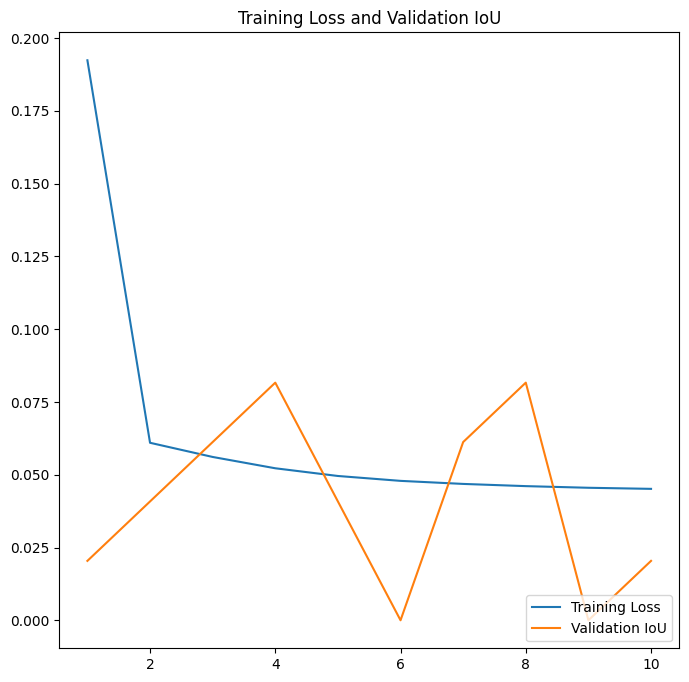

In [14]:

# ----- visualize train_result -----
epoch_range = range(1, n_epochs + 1)

# (1) plotting
plt.figure(figsize=(8, 8))
plt.plot(epoch_range, train_result[0], label='Training Loss')
plt.plot(epoch_range, train_result[1], label='Validation IoU')
plt.legend(loc='lower right')
plt.title('Training Loss and Validation IoU')
plt.show()